In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time
import numpy as np
import spacy
import random
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import re
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
import urllib.request
import zipfile
import io
from torch.cuda.amp import autocast, GradScaler

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
SEED = 9191
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
try:
    spacy_de = spacy.load('de_core_news_sm')
    spacy_en = spacy.load('en_core_web_sm')
except OSError:
    import subprocess
    subprocess.run(['python3', '-m', 'spacy', 'download', 'de_core_news_sm'])
    subprocess.run(['python3', '-m', 'spacy', 'download', 'en_core_web_sm'])
    spacy_de = spacy.load('de_core_news_sm')
    spacy_en = spacy.load('en_core_web_sm')

def tokenize_de(text):
    return [token.text.lower() for token in spacy_de(text)]

def tokenize_en(text):
    return [token.text.lower() for token in spacy_en(text)]

# Define special tokens
BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'
special_tokens = [UNK_TOKEN, PAD_TOKEN, BOS_TOKEN, EOS_TOKEN]

In [5]:
class Vocabulary:
    def __init__(self, special_tokens=None):
        self.token_to_idx = {}
        self.idx_to_token = []
        self.freqs = {}
        
        if special_tokens:
            for token in special_tokens:
                self.add_token(token)
        
        self.unk_idx = self.token_to_idx.get(UNK_TOKEN, 0)
    
    def add_token(self, token):
        if token not in self.token_to_idx:
            self.token_to_idx[token] = len(self.idx_to_token)
            self.idx_to_token.append(token)
            self.freqs[token] = 1
        else:
            self.freqs[token] += 1
    
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, token):
        return self.token_to_idx.get(token, self.unk_idx)
    
    def lookup_token(self, idx):
        if 0 <= idx < len(self.idx_to_token):
            return self.idx_to_token[idx]
        return self.idx_to_token[self.unk_idx]
    
    def lookup_tokens(self, indices):
        return [self.lookup_token(idx) for idx in indices]
    
    def save(self, path):
        torch.save({
            'token_to_idx': self.token_to_idx,
            'idx_to_token': self.idx_to_token,
            'freqs': self.freqs,
            'unk_idx': self.unk_idx
        }, path)
    
    @classmethod
    def load(cls, path):
        data = torch.load(path)
        vocab = cls()
        vocab.token_to_idx = data['token_to_idx']
        vocab.idx_to_token = data['idx_to_token']
        vocab.freqs = data['freqs']
        vocab.unk_idx = data['unk_idx']
        return vocab

In [6]:
def build_vocab_from_data(data, tokenizer, min_freq=2, special_tokens=None):
    """Build vocabulary from data"""
    vocab = Vocabulary(special_tokens)
    counter = {}
    
    # Count tokens
    for text in data:
        tokens = tokenizer(text)
        for token in tokens:
            counter[token] = counter.get(token, 0) + 1
    
    # Add tokens that meet the minimum frequency
    for token, count in counter.items():
        if count >= min_freq:
            vocab.add_token(token)
    
    return vocab

In [7]:
def download_multi30k():
    base_url = "https://github.com/multi30k/dataset/raw/master/"
    
    os.makedirs("data", exist_ok=True)
    
    for lang in ['de', 'en']:
        url = f"{base_url}data/task1/raw/train.{lang}.gz"
        path = f"data/train.{lang}"
        
        if not os.path.exists(path):
            print(f"Downloading {url}...")
            import gzip
            with urllib.request.urlopen(url) as response:
                with gzip.GzipFile(fileobj=io.BytesIO(response.read())) as uncompressed:
                    file_content = uncompressed.read()
            
            with open(path, 'wb') as f:
                f.write(file_content)
    
    for lang in ['de', 'en']:
        url = f"{base_url}data/task1/raw/val.{lang}.gz"
        path = f"data/val.{lang}"
        
        if not os.path.exists(path):
            print(f"Downloading {url}...")
            import gzip
            with urllib.request.urlopen(url) as response:
                with gzip.GzipFile(fileobj=io.BytesIO(response.read())) as uncompressed:
                    file_content = uncompressed.read()
            
            with open(path, 'wb') as f:
                f.write(file_content)
    
    for lang in ['de', 'en']:
        url = f"{base_url}data/task1/raw/test_2016_flickr.{lang}.gz"
        path = f"data/test.{lang}"
        
        if not os.path.exists(path):
            print(f"Downloading {url}...")
            import gzip
            with urllib.request.urlopen(url) as response:
                with gzip.GzipFile(fileobj=io.BytesIO(response.read())) as uncompressed:
                    file_content = uncompressed.read()
            
            with open(path, 'wb') as f:
                f.write(file_content)
    
    print("Multi30k dataset downloaded successfully.")

In [8]:
def read_data(src_path, tgt_path):
    with open(src_path, 'r', encoding='utf-8') as src_file, open(tgt_path, 'r', encoding='utf-8') as tgt_file:
        src_lines = src_file.readlines()
        tgt_lines = tgt_file.readlines()
    
    pairs = [(src.strip(), tgt.strip()) for src, tgt in zip(src_lines, tgt_lines)]
    
    return pairs

In [9]:
def prepare_data():
    download_multi30k()
    
    train_data = read_data("data/train.de", "data/train.en")
    val_data = read_data("data/val.de", "data/val.en")
    test_data = read_data("data/test.de", "data/test.en")
    
    de_train_sentences = [pair[0] for pair in train_data]
    en_train_sentences = [pair[1] for pair in train_data]
    
    de_vocab = build_vocab_from_data(de_train_sentences, tokenize_de, special_tokens=special_tokens)
    en_vocab = build_vocab_from_data(en_train_sentences, tokenize_en, special_tokens=special_tokens)
    
    return train_data, val_data, test_data, de_vocab, en_vocab

In [10]:
class TranslationDataset(Dataset):
    def __init__(self, data, src_vocab, tgt_vocab, src_tokenizer, tgt_tokenizer):
        self.data = data
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        src_text, tgt_text = self.data[idx]
        
        # Tokenize and convert to indices
        src_tokens = self.src_tokenizer(src_text)
        tgt_tokens = self.tgt_tokenizer(tgt_text)
        
        # Add BOS and EOS tokens to target
        src_indices = [self.src_vocab[token] for token in src_tokens]
        tgt_indices = [self.tgt_vocab[BOS_TOKEN]] + [self.tgt_vocab[token] for token in tgt_tokens] + [self.tgt_vocab[EOS_TOKEN]]
        
        return torch.tensor(src_indices), torch.tensor(tgt_indices)

In [11]:
def collate_fn(batch, pad_idx):
    src_batch, tgt_batch = [], []
    for src, tgt in batch:
        src_batch.append(src)
        tgt_batch.append(tgt)
    
    # Pad sequences
    src_batch = pad_sequence(src_batch, padding_value=pad_idx, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=pad_idx, batch_first=True)
    
    return src_batch, tgt_batch

In [12]:
def create_dataloaders(train_data, val_data, test_data, de_vocab, en_vocab, batch_size=128):
    """Create DataLoader objects for training, validation and testing"""
    train_dataset = TranslationDataset(train_data, de_vocab, en_vocab, tokenize_de, tokenize_en)
    val_dataset = TranslationDataset(val_data, de_vocab, en_vocab, tokenize_de, tokenize_en)
    test_dataset = TranslationDataset(test_data, de_vocab, en_vocab, tokenize_de, tokenize_en)
    
    # Get pad index
    pad_idx = de_vocab[PAD_TOKEN]
    
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=lambda batch: collate_fn(batch, pad_idx),
        pin_memory=True,
        num_workers=12
    )
    
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=lambda batch: collate_fn(batch, pad_idx),
        pin_memory=True,
        num_workers=12
    )
    
    test_dataloader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=lambda batch: collate_fn(batch, pad_idx),
        pin_memory=True,
        num_workers=12
    )
    
    return train_dataloader, val_dataloader, test_dataloader, train_dataset, val_dataset, test_dataset

In [13]:
def generate_square_subsequent_mask(sz):
    """Generate a mask for subsequent positions"""
    mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
    return mask.to(device)

def create_key_padding_mask(matrix, pad_idx):
    """Create mask where True means to mask (pad token)"""
    return (matrix == pad_idx).to(device)  # Shape: [batch_size, seq_len]

In [14]:
class TransformerModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=256, nhead=8, 
                 num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=1024, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.d_model = d_model
        self.nhead = nhead
    
        # Embeddings
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)
        
        # PyTorch's Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers,
            norm=nn.LayerNorm(d_model)  # Explicitly add norm
        )
        
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_decoder_layers,
            norm=nn.LayerNorm(d_model)  # Explicitly add norm
        )
        
        # Output projection
        self.output_layer = nn.Linear(d_model, tgt_vocab_size)
        
        # Initialize parameters
        self._init_parameters()
        
        self.d_model = d_model
        self.nhead = nhead
        
    def _init_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                # Use Kaiming initialization instead of Xavier
                nn.init.kaiming_uniform_(p, a=math.sqrt(5))
                
        # Initialize embedding with normal distribution
        nn.init.normal_(self.src_embedding.weight, mean=0, std=self.d_model ** -0.5)
        nn.init.normal_(self.tgt_embedding.weight, mean=0, std=self.d_model ** -0.5)
        
        # Special initialization for output layer
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.constant_(self.output_layer.bias, 0.)
    
    def forward(self, src, tgt, src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, tgt_mask=None):
        # Embed source tokens
        src = self.src_embedding(src) * math.sqrt(self.d_model)
        src = self.positional_encoding(src)
        
        # Embed target tokens
        tgt = self.tgt_embedding(tgt) * math.sqrt(self.d_model)
        tgt = self.positional_encoding(tgt)
        
        # Pass through transformer encoder - note the inversion of masks!
        memory = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask)
        
        # Pass through transformer decoder - note the inversion of masks!
        output = self.transformer_decoder(
            tgt, 
            memory, 
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )
        
        # Output projection
        return self.output_layer(output)

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [16]:
def train_epoch(model, dataloader, optimizer, criterion, epoch, clip_grad=1.0):
    model.train()
    total_loss = 0
    processed_batches = 0
    
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}')
    
    for src, tgt in progress_bar:
        src = src.to(device)
        tgt = tgt.to(device)
        
        # Prepare masks
        src_key_padding_mask = create_key_padding_mask(src, pad_idx)  # [batch_size, src_len]
        tgt_input = tgt[:, :-1]  # Remove the last token (EOS)
        tgt_output = tgt[:, 1:]  # Remove the first token (BOS)
        tgt_key_padding_mask = create_key_padding_mask(tgt_input, pad_idx)  # [batch_size, tgt_len-1]
        tgt_mask = generate_square_subsequent_mask(tgt_input.size(1))  # [tgt_len-1, tgt_len-1]
        
        # Forward pass
        optimizer.zero_grad()
        output = model(
            src, 
            tgt_input, 
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=src_key_padding_mask,
            tgt_mask=tgt_mask
        )
        
        # Calculate loss
        output = output.reshape(-1, output.shape[-1])
        tgt_output = tgt_output.reshape(-1)
        loss = criterion(output, tgt_output)
        
        # Backward pass
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        
        # Update parameters
        optimizer.step()
        
        # Update statistics
        total_loss += loss.item()
        processed_batches += 1
        progress_bar.set_postfix({'loss': total_loss / processed_batches})
    
    return total_loss / processed_batches

In [17]:
def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    processed_batches = 0
    
    with torch.no_grad():
        for src, tgt in tqdm(dataloader, desc='Validating'):
            src = src.to(device)
            tgt = tgt.to(device)
            
            # Prepare masks
            src_key_padding_mask = create_key_padding_mask(src, pad_idx)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            tgt_key_padding_mask = create_key_padding_mask(tgt_input, pad_idx)
            tgt_mask = generate_square_subsequent_mask(tgt_input.size(1))
            
            # Forward pass
            output = model(
                src, 
                tgt_input, 
                src_key_padding_mask=src_key_padding_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=src_key_padding_mask,
                tgt_mask=tgt_mask
            )
            
            # Calculate loss
            output = output.reshape(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            loss = criterion(output, tgt_output)
            
            # Update statistics
            total_loss += loss.item()
            processed_batches += 1
    
    return total_loss / processed_batches

In [18]:
def greedy_decode(model, src, max_len, start_token, end_token, pad_token):
    model.eval()
    
    src = src.to(device)
    src_padding_mask = create_pad_mask(src, pad_token)
    
    # Initialize target sequence with start token
    ys = torch.ones(1, 1).fill_(start_token).type_as(src).to(device)
    
    for i in range(max_len - 1):
        # Generate mask for target sequence
        tgt_mask = generate_square_subsequent_mask(ys.size(1)).to(device)
        tgt_padding_mask = create_pad_mask(ys, pad_token)
        
        # Decode one step
        with torch.no_grad():
            out = model(src, ys, src_padding_mask, tgt_padding_mask, tgt_mask)
            prob = F.softmax(out[:, -1], dim=-1)
            _, next_word = torch.max(prob, dim=1)
            
        # Add predicted token to sequence
        next_word = next_word.item()
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src).fill_(next_word).to(device)], dim=1)
        
        # Stop if end token is predicted
        if next_word == end_token:
            break
    
    return ys

In [19]:
def beam_search_decode(model, src, max_len, start_token, end_token, pad_token, beam_size=5):
    model.eval()
    
    src = src.to(device)
    src_key_padding_mask = create_key_padding_mask(src, pad_token)
    
    # Initialize with start token
    ys = torch.ones(1, 1).fill_(start_token).type_as(src).to(device)
    
    # Initial beam
    beams = [(ys, 0.0)]  # (sequence, score)
    completed_beams = []
    
    for _ in range(max_len - 1):
        candidates = []
        
        for seq, score in beams:
            if seq[0, -1].item() == end_token:
                completed_beams.append((seq, score))
                continue
                
            # Prepare masks
            tgt_mask = generate_square_subsequent_mask(seq.size(1))
            tgt_key_padding_mask = create_key_padding_mask(seq, pad_token)
            
            # Decode one step
            with torch.no_grad():
                out = model(
                    src, 
                    seq, 
                    src_key_padding_mask=src_key_padding_mask,
                    tgt_key_padding_mask=tgt_key_padding_mask,
                    memory_key_padding_mask=src_key_padding_mask,
                    tgt_mask=tgt_mask
                )
                prob = F.log_softmax(out[:, -1], dim=-1)
                
            # Get top k
            topk_prob, topk_idx = prob.topk(beam_size)
            
            for i in range(beam_size):
                next_token = topk_idx[0, i].item()
                next_score = score + topk_prob[0, i].item()
                next_seq = torch.cat([seq, torch.ones(1, 1).type_as(src).fill_(next_token).to(device)], dim=1)
                candidates.append((next_seq, next_score))
        
        # Keep only top beams
        beams = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_size]
        
        # Stop if all beams end with end token
        if all(beam[0][0, -1].item() == end_token for beam in beams):
            break
    
    # Add any remaining beams to completed
    for seq, score in beams:
        if seq[0, -1].item() != end_token:
            seq = torch.cat([seq, torch.ones(1, 1).type_as(src).fill_(end_token).to(device)], dim=1)
        completed_beams.append((seq, score))
    
    # Return the highest scoring beam
    if completed_beams:
        return max(completed_beams, key=lambda x: x[1])[0]
    else:
        # If no completed beams, return the best ongoing beam
        return beams[0][0]

In [20]:
def translate(model, sentence, src_tokenizer, tgt_vocab, src_vocab, max_len=50, beam_size=5):
    model.eval()
    
    # Tokenize input sentence
    tokens = src_tokenizer(sentence)
    
    # Convert tokens to indices
    token_ids = [src_vocab[token] for token in tokens]
    
    # Create tensor
    src = torch.tensor([token_ids]).to(device)
    
    # Decode using beam search
    output = beam_search_decode(
        model, 
        src, 
        max_len, 
        tgt_vocab[BOS_TOKEN], 
        tgt_vocab[EOS_TOKEN], 
        src_vocab[PAD_TOKEN],
        beam_size
    )
    
    # Convert output indices to tokens
    output_tokens = [tgt_vocab.lookup_token(i) for i in output[0, 1:].tolist()]
    
    # Stop at EOS token
    if tgt_vocab[EOS_TOKEN] in output_tokens:
        output_tokens = output_tokens[:output_tokens.index(tgt_vocab[EOS_TOKEN])]
    
    return ' '.join(output_tokens)

In [21]:
def calculate_bleu(references, hypotheses):
    """Calculate BLEU score"""
    # Function to compute n-gram precision
    def ngram_precision(hypothesis, reference, n):
        hyp_ngrams = [tuple(hypothesis[i:i+n]) for i in range(len(hypothesis) - n + 1)]
        ref_ngrams = [tuple(reference[i:i+n]) for i in range(len(reference) - n + 1)]
        
        if not hyp_ngrams:
            return 0
        
        matches = sum(1 for ngram in hyp_ngrams if ngram in ref_ngrams)
        return matches / len(hyp_ngrams) if hyp_ngrams else 0
    
    # Calculate individual n-gram precisions
    precisions = []
    for n in range(1, 5):  # 1-gram to 4-gram
        precision_sum = 0
        for hyp, refs in zip(hypotheses, references):
            # Use the maximum precision among all references
            precision_sum += max(ngram_precision(hyp, ref, n) for ref in refs)
        precisions.append(precision_sum / len(hypotheses) if hypotheses else 0)
    
    # Brevity penalty
    hyp_lengths = [len(hyp) for hyp in hypotheses]
    closest_ref_lengths = []
    for hyp, refs in zip(hypotheses, references):
        hyp_len = len(hyp)
        closest_ref_len = min(refs, key=lambda ref: abs(len(ref) - hyp_len))
        closest_ref_lengths.append(len(closest_ref_len))
    
    bp = 1.0
    if sum(hyp_lengths) < sum(closest_ref_lengths):
        bp = math.exp(1 - sum(closest_ref_lengths) / sum(hyp_lengths))
    
    # Geometric mean of precisions
    if 0 in precisions:
        return 0
    
    geo_mean = math.exp(sum(math.log(p) for p in precisions) / len(precisions))
    
    return bp * geo_mean

In [22]:
def evaluate_model(model, test_dataloader, src_vocab, tgt_vocab, num_examples=100):
    model.eval()
    references = []
    hypotheses = []
    
    with torch.no_grad():
        for src, tgt in tqdm(test_dataloader, desc="Evaluating"):
            src = src.to(device)
            
            # For each sentence in the batch
            for i in range(src.size(0)):
                # Get source sentence
                src_sentence = src[i].unsqueeze(0)
                
                # Translate using beam search
                output = beam_search_decode(
                    model, 
                    src_sentence, 
                    max_len=50, 
                    start_token=tgt_vocab[BOS_TOKEN], 
                    end_token=tgt_vocab[EOS_TOKEN], 
                    pad_token=src_vocab[PAD_TOKEN],
                    beam_size=3
                )
                
                # Convert output indices to tokens
                pred_tokens = [tgt_vocab.lookup_token(idx) for idx in output[0, 1:].tolist()]
                
                # Stop at EOS token
                if tgt_vocab.lookup_token(tgt_vocab[EOS_TOKEN]) in pred_tokens:
                    pred_tokens = pred_tokens[:pred_tokens.index(tgt_vocab.lookup_token(tgt_vocab[EOS_TOKEN]))]
                
                # Convert reference indices to tokens
                ref_tokens = [tgt_vocab.lookup_token(idx) for idx in tgt[i, 1:].tolist()]
                
                # Stop at EOS token or PAD token
                if tgt_vocab.lookup_token(tgt_vocab[EOS_TOKEN]) in ref_tokens:
                    ref_tokens = ref_tokens[:ref_tokens.index(tgt_vocab.lookup_token(tgt_vocab[EOS_TOKEN]))]
                elif tgt_vocab.lookup_token(tgt_vocab[PAD_TOKEN]) in ref_tokens:
                    ref_tokens = ref_tokens[:ref_tokens.index(tgt_vocab.lookup_token(tgt_vocab[PAD_TOKEN]))]
                
                hypotheses.append(pred_tokens)
                references.append([ref_tokens])  # BLEU expects a list of references
            
            # To save time, only use a subset of the test set
            if len(hypotheses) >= num_examples:
                break
    
    # Calculate BLEU score
    bleu = calculate_bleu(references, hypotheses)
    
    return bleu, references, hypotheses

In [23]:
def load_model(model_path, de_vocab, en_vocab):
    """Load model and vocabularies from saved file"""
    checkpoint = torch.load(model_path)
    
    # Get hyperparameters
    params = checkpoint['model_hyperparams']
    
    # Initialize model
    model = TransformerModel(
        len(de_vocab),
        len(en_vocab),
        d_model=params['d_model'],
        nhead=params['nhead'],
        num_encoder_layers=params['num_encoder_layers'],
        num_decoder_layers=params['num_decoder_layers'],
        dim_feedforward=params['dim_feedforward'],
        dropout=params['dropout']
    ).to(device)
    
    # Load state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model

In [24]:
print("Preparing Multi30k dataset...")
train_data, val_data, test_data, de_vocab, en_vocab = prepare_data()

Preparing Multi30k dataset...
Multi30k dataset downloaded successfully.


In [25]:
print(f"German vocabulary size: {len(de_vocab)}")
print(f"English vocabulary size: {len(en_vocab)}")

German vocabulary size: 7853
English vocabulary size: 5893


In [32]:
D_MODEL = 512
NHEAD = 8
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6
DIM_FEEDFORWARD = 2048
DROPOUT = 0.1
BATCH_SIZE = 128  # Increased for better GPU utilization
LR = 0.0005
BETAS = (0.9, 0.98)
EPS = 1e-9
WARMUP_STEPS = 4000
NUM_EPOCHS = 100
pad_idx = de_vocab[PAD_TOKEN]

In [33]:
train_dataloader, val_dataloader, test_dataloader, train_dataset, val_dataset, test_dataset = create_dataloaders(
    train_data, val_data, test_data, de_vocab, en_vocab, batch_size=BATCH_SIZE
)

In [34]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(val_data)}")
print(f"Number of test examples: {len(test_data)}")
print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(val_dataloader)}")
print(f"Number of test batches: {len(test_dataloader)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of test examples: 1000
Number of training batches: 227
Number of validation batches: 8
Number of test batches: 8


In [35]:
model = TransformerModel(
    len(de_vocab), 
    len(en_vocab), 
    d_model=D_MODEL, 
    nhead=NHEAD,
    num_encoder_layers=NUM_ENCODER_LAYERS, 
    num_decoder_layers=NUM_DECODER_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD, 
    dropout=DROPOUT
).to(device)

print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")

Model has 54201605 parameters


In [36]:
def lr_schedule(step, d_model, warmup_steps):
    arg1 = step ** -0.5
    arg2 = step * (warmup_steps ** -1.5)
    return (d_model ** -0.5) * min(arg1, arg2)

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.98), eps=1e-9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, verbose=True)
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx, label_smoothing=0.1)  # Add label smoothing
scaler = GradScaler()

Starting training...


Epoch 1:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 4.7263, Val Loss: 4.1702, LR: 0.000500
Saved best model with validation loss: 4.1702


Epoch 2:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2/100, Train Loss: 4.0948, Val Loss: 3.9925, LR: 0.000500
Saved best model with validation loss: 3.9925


Epoch 3:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3/100, Train Loss: 3.8946, Val Loss: 3.9756, LR: 0.000500
Saved best model with validation loss: 3.9756


Epoch 4:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4/100, Train Loss: 3.7454, Val Loss: 3.9827, LR: 0.000500


Epoch 5:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5/100, Train Loss: 3.6112, Val Loss: 4.0497, LR: 0.000500


Epoch 6:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6/100, Train Loss: 3.4858, Val Loss: 4.1331, LR: 0.000500


Epoch 7:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7/100, Train Loss: 3.3623, Val Loss: 4.1523, LR: 0.000500


Epoch 8:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8/100, Train Loss: 3.2420, Val Loss: 4.2104, LR: 0.000500


Epoch 9:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9/100, Train Loss: 3.1291, Val Loss: 4.3538, LR: 0.000500


Epoch 10:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10/100, Train Loss: 3.0201, Val Loss: 4.3620, LR: 0.000500


Epoch 11:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11/100, Train Loss: 2.9224, Val Loss: 4.3204, LR: 0.000500


Epoch 12:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12/100, Train Loss: 2.8294, Val Loss: 4.5254, LR: 0.000500


Epoch 13:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13/100, Train Loss: 2.7518, Val Loss: 4.5604, LR: 0.000500


Epoch 14:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14/100, Train Loss: 2.6796, Val Loss: 4.6168, LR: 0.000500


Epoch 15:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15/100, Train Loss: 2.6225, Val Loss: 4.6828, LR: 0.000500


Epoch 16:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16/100, Train Loss: 2.5690, Val Loss: 4.8095, LR: 0.000500


Epoch 17:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17/100, Train Loss: 2.5269, Val Loss: 4.7534, LR: 0.000500


Epoch 18:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18/100, Train Loss: 2.4908, Val Loss: 4.8127, LR: 0.000500


Epoch 19:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19/100, Train Loss: 2.4596, Val Loss: 4.8239, LR: 0.000500


Epoch 20:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20/100, Train Loss: 2.4311, Val Loss: 4.8329, LR: 0.000500


Epoch 21:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 21/100, Train Loss: 2.4095, Val Loss: 4.8841, LR: 0.000500


Epoch 22:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 22/100, Train Loss: 2.3898, Val Loss: 4.8665, LR: 0.000500


Epoch 23:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 23/100, Train Loss: 2.3755, Val Loss: 4.8478, LR: 0.000500


Epoch 24:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 24/100, Train Loss: 2.3577, Val Loss: 4.9300, LR: 0.000500


Epoch 25:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 25/100, Train Loss: 2.3400, Val Loss: 4.9805, LR: 0.000500


Epoch 26:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 26/100, Train Loss: 2.3269, Val Loss: 4.9554, LR: 0.000500


Epoch 27:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 27/100, Train Loss: 2.3143, Val Loss: 5.0180, LR: 0.000500


Epoch 28:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 28/100, Train Loss: 2.3029, Val Loss: 4.9772, LR: 0.000500


Epoch 29:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 29/100, Train Loss: 2.2952, Val Loss: 4.9758, LR: 0.000500


Epoch 30:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 30/100, Train Loss: 2.2879, Val Loss: 4.9613, LR: 0.000500


Epoch 31:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 31/100, Train Loss: 2.2776, Val Loss: 5.0306, LR: 0.000500


Epoch 32:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 32/100, Train Loss: 2.2685, Val Loss: 4.9599, LR: 0.000500


Epoch 33:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 33/100, Train Loss: 2.2609, Val Loss: 4.9655, LR: 0.000500


Epoch 34:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 34/100, Train Loss: 2.2545, Val Loss: 4.9989, LR: 0.000500


Epoch 35:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 35/100, Train Loss: 2.2484, Val Loss: 5.0513, LR: 0.000500


Epoch 36:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 36/100, Train Loss: 2.2417, Val Loss: 5.0794, LR: 0.000500


Epoch 37:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 37/100, Train Loss: 2.2336, Val Loss: 5.1317, LR: 0.000500


Epoch 38:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 38/100, Train Loss: 2.2273, Val Loss: 5.1241, LR: 0.000500


Epoch 39:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 39/100, Train Loss: 2.2227, Val Loss: 5.1236, LR: 0.000500


Epoch 40:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 40/100, Train Loss: 2.2206, Val Loss: 5.0804, LR: 0.000500


Epoch 41:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 41/100, Train Loss: 2.2215, Val Loss: 5.0751, LR: 0.000500


Epoch 42:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 42/100, Train Loss: 2.2164, Val Loss: 5.1300, LR: 0.000500


Epoch 43:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 43/100, Train Loss: 2.2092, Val Loss: 5.1340, LR: 0.000500


Epoch 44:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 44/100, Train Loss: 2.2065, Val Loss: 5.1731, LR: 0.000500


Epoch 45:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 45/100, Train Loss: 2.2013, Val Loss: 5.1720, LR: 0.000500


Epoch 46:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 46/100, Train Loss: 2.1997, Val Loss: 5.1242, LR: 0.000500


Epoch 47:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 47/100, Train Loss: 2.1954, Val Loss: 5.1828, LR: 0.000500


Epoch 48:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 48/100, Train Loss: 2.1887, Val Loss: 5.2166, LR: 0.000500


Epoch 49:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 49/100, Train Loss: 2.1864, Val Loss: 5.1649, LR: 0.000500


Epoch 50:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 50/100, Train Loss: 2.1820, Val Loss: 5.1470, LR: 0.000500


Epoch 51:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 51/100, Train Loss: 2.1788, Val Loss: 5.1545, LR: 0.000500


Epoch 52:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 52/100, Train Loss: 2.1758, Val Loss: 5.1279, LR: 0.000500


Epoch 53:   0%|          | 0/227 [00:00<?, ?it/s]

Validating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 53/100, Train Loss: 2.1728, Val Loss: 5.2796, LR: 0.000500
Early stopping after 53 epochs


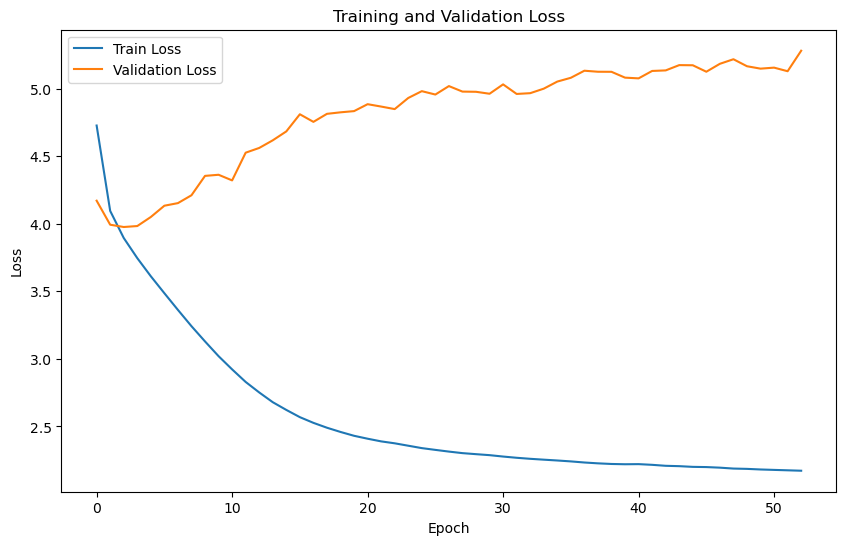

In [38]:
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 50  #Increased patience
early_stop_counter = 0


print("Starting training...")

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss = train_epoch(model, train_dataloader, optimizer, criterion, epoch)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = validate(model, val_dataloader, criterion)
    val_losses.append(val_loss)
    
    # Update learning rate based on validation performance
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'epoch': epoch,
            'val_loss': val_loss,
            'de_vocab_dict': {
                'token_to_idx': de_vocab.token_to_idx,
                'idx_to_token': de_vocab.idx_to_token,
                'freqs': de_vocab.freqs,
                'unk_idx': de_vocab.unk_idx
            },
            'en_vocab_dict': {
                'token_to_idx': en_vocab.token_to_idx,
                'idx_to_token': en_vocab.idx_to_token,
                'freqs': en_vocab.freqs,
                'unk_idx': en_vocab.unk_idx
            },
            'model_hyperparams': {
                'd_model': D_MODEL,
                'nhead': NHEAD,
                'num_encoder_layers': NUM_ENCODER_LAYERS,
                'num_decoder_layers': NUM_DECODER_LAYERS,
                'dim_feedforward': DIM_FEEDFORWARD,
                'dropout': DROPOUT
            }
        }, 'best_transformer_model.pt')
        print(f"Saved best model with validation loss: {best_val_loss:.4f}")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    
    # Early stopping
    if early_stop_counter >= patience:
        print(f"Early stopping after {epoch+1} epochs")
        break

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig('loss_plot.png')
plt.show()

In [39]:
try:
    model = load_model('best_transformer_model.pt', de_vocab, en_vocab)
    print("Loaded best model for evaluation")
except FileNotFoundError:
    print("Using the last trained model for evaluation")

Loaded best model for evaluation


In [40]:
test_sentences = [
    "Ich gehe zur Schule.",
    "Obwohl es regnete, ging sie ohne Regenschirm spazieren.",
    "Der Klimawandel ist ein globales Problem.",
    "Berlin ist die Hauptstadt von Deutschland.",
    "Ein weißer Hund mit einem Halsband läuft auf einer eingezäunten Rasenfläche umher."
]

In [41]:
print("\nTranslation Examples:")
for sentence in test_sentences:
    translation = translate(model, sentence, tokenize_de, en_vocab, de_vocab)
    print(f"German: {sentence}")
    print(f"English (model): {translation}")
    print("-" * 50)

# print("\nEvaluating model on test set...")
# bleu, references, hypotheses = evaluate_model(model, test_dataloader, de_vocab, en_vocab, num_examples=100)
# print(f"BLEU Score: {bleu:.4f}")

# print("\nTest Set Translation Examples:")
# for i in range(min(5, len(hypotheses))):
#     print(f"Reference: {' '.join(references[i][0])}")
#     print(f"Hypothesis: {' '.join(hypotheses[i])}")
#     print("-" * 50)



Translation Examples:
German: Ich gehe zur Schule.
English (model): a man in a white shirt and blue jeans is walking down the street . </s>
--------------------------------------------------
German: Obwohl es regnete, ging sie ohne Regenschirm spazieren.
English (model): a man in a white shirt and blue jeans is walking down the street . </s>
--------------------------------------------------
German: Der Klimawandel ist ein globales Problem.
English (model): a man in a white shirt and blue jeans is walking down the street . </s>
--------------------------------------------------
German: Berlin ist die Hauptstadt von Deutschland.
English (model): a man in a white shirt and blue jeans is walking down the street . </s>
--------------------------------------------------
German: Ein weißer Hund mit einem Halsband läuft auf einer eingezäunten Rasenfläche umher.
English (model): a man in a white shirt and blue jeans is walking down the street . </s>
-------------------------------------------